# 1D Differential Equation


## cliburn sta-663-2015

https://github.com/cliburn/sta-663-2015/blob/master/Lectures/Topic10_Practical_Optimization/BlackBoxOptimization.ipynb  
https://people.duke.edu/~ccc14/  

    
This is a specialized application of curve_fit, in which the curve to be fitted is defined implcitly by an ordinary differentail equation 

$$\frac{dx}{dt} = -kx$$ 

and we want to use observed data to estiamte the parameters $k$ and the initial value $x_0$. Of course this can be explicitly solved but the same approach can be used to find multiple paraemters for $n$-dimensional systems of ODEs.

In [5]:

import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.optimize import curve_fit


%matplotlib inline
%precision 4
plt.style.use('ggplot')

In [6]:
from scipy.integrate import odeint

def f(x, t, k):
    """Simple exponential decay."""
    return -k*x

def x(t, k, x0):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    x = odeint(f, x0, t, args=(k,))
    return x.ravel()

In [7]:

# True parameter values
x0_ = 10
k_ = 0.1*np.pi

# Some random data genererated from closed form soltuion plus Gaussian noise
ts = np.sort(np.random.uniform(0, 10, 200))
xs = x0_*np.exp(-k_*ts) + np.random.normal(0,0.1,200)

popt, cov = curve_fit(x, ts, xs)
k_opt, x0_opt = popt

print("k = %g" % k_opt)
print("x0 = %g" % x0_opt)

k = 0.313477
x0 = 9.7958


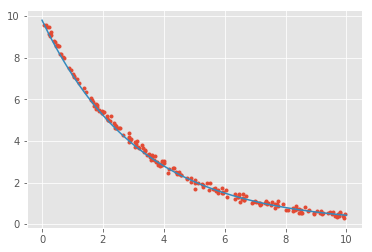

In [8]:
import matplotlib.pyplot as plt
t = np.linspace(0, 10, 100)
plt.plot(ts, xs, '.', t, x(t, k_opt, x0_opt), '-');

https://people.duke.edu/~ccc14/sta-663/CalibratingODEs.html

In [15]:
from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.integrate import odeint

def f(xs, t, ps):
    """Receptor synthesis-internalization model."""
    try:
        a = ps['a'].value
        b = ps['b'].value
    except:
        a, b = ps
    x = xs

    return a - b*x

def g(t, x0, ps):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    x = odeint(f, x0, t, args=(ps,))
    return x

def residual(ps, ts, data):
    x0 = ps['x0'].value
    model = g(ts, x0, ps)
    return (model - data).ravel()

a = 2.0
b = 0.5
true_params = [a, b]
x0 = 10.0

t = np.linspace(0, 10, 10)
data = g(t, x0, true_params)
data += np.random.normal(size=data.shape)

# set parameters incluing bounds
params = Parameters()
params.add('x0', value=float(data[0]), min=0, max=100)
params.add('a', value= 1.0, min=0, max=10)
params.add('b', value= 1.0, min=0, max=10)

# fit model and find predicted values
result = minimize(residual, params, args=(t, data), method='leastsq')
final = data + result.residual.reshape(data.shape)

# plot data and fitted curves
plt.plot(t, data, 'o')
plt.plot(t, final, '--', linewidth=2, c='blue');

# display fitted statistics
report_fit(result)

ModuleNotFoundError: No module named 'lmfit'

## Fitting data to system of ODEs using Python via Scipy & Numpy


https://stackoverflow.com/questions/11278836/fitting-data-to-system-of-odes-using-python-via-scipy-numpy

parameter values are  [0.5222 0.1817]


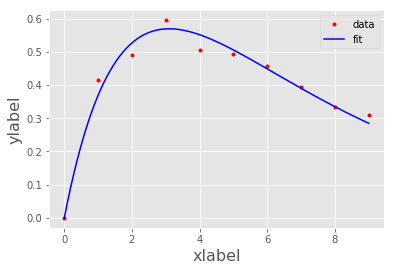

In [11]:
import pylab as pp
import numpy as np
from scipy import integrate, interpolate
from scipy import optimize

##initialize the data
x_data = np.linspace(0,9,10)
y_data = np.array([0.000,0.416,0.489,0.595,0.506,0.493,0.458,0.394,0.335,0.309])


def f(y, t, k): 
    """define the ODE system in terms of 
        dependent variable y,
        independent variable t, and
        optinal parmaeters, in this case a single variable k """
    return (-k[0]*y[0],
          k[0]*y[0]-k[1]*y[1],
          k[1]*y[1])

def my_ls_func(x,teta):
    """definition of function for LS fit
        x gives evaluation points,
        teta is an array of parameters to be varied for fit"""
    # create an alias to f which passes the optional params    
    f2 = lambda y,t: f(y, t, teta)
    # calculate ode solution, retuen values for each entry of "x"
    r = integrate.odeint(f2,y0,x)
    #in this case, we only need one of the dependent variable values
    return r[:,1]

def f_resid(p):
    """ function to pass to optimize.leastsq
        The routine will square and sum the values returned by 
        this function""" 
    return y_data-my_ls_func(x_data,p)
#solve the system - the solution is in variable c
guess = [0.2,0.3] #initial guess for params
y0 = [1,0,0] #inital conditions for ODEs
(c,kvg) = optimize.leastsq(f_resid, guess) #get params

print("parameter values are ",c)

# fit ODE results to interpolating spline just for fun
xeval=np.linspace(min(x_data), max(x_data),30) 
gls = interpolate.UnivariateSpline(xeval, my_ls_func(xeval,c), k=3, s=0)

#pick a few more points for a very smooth curve, then plot 
#   data and curve fit
xeval=np.linspace(min(x_data), max(x_data),200)
#Plot of the data as red dots and fit as blue line
pp.plot(x_data, y_data,'.r',xeval,gls(xeval),'-b')
pp.xlabel('xlabel',{"fontsize":16})
pp.ylabel("ylabel",{"fontsize":16})
pp.legend(('data','fit'),loc=0)
pp.show()

parameter values are  [0.5222 0.1817] 1


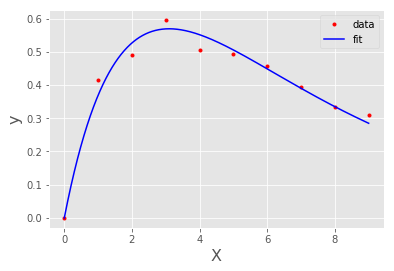

In [14]:
# cleaned up a bit to get my head around it - thanks for sharing 
import pylab as pp
import numpy as np
from scipy import integrate, optimize

class Parameterize_ODE():
    def __init__(self):
        self.X = np.linspace(0,9,10)
        self.y = np.array([0.000,0.416,0.489,0.595,0.506,0.493,0.458,0.394,0.335,0.309])
        self.y0 = [1,0,0] # inital conditions ODEs
    def ode(self, y, X, p):
        return (-p[0]*y[0],
                 p[0]*y[0]-p[1]*y[1],
                           p[1]*y[1])
    def model(self, X, p):
        return integrate.odeint(self.ode, self.y0, X, args=(p,))
    def f_resid(self, p):
        return self.y - self.model(self.X, p)[:,1]
    def optim(self, p_quess):
        return optimize.leastsq(self.f_resid, p_guess) # fit params

po = Parameterize_ODE(); p_guess = [0.2, 0.3] 
c, kvg = po.optim(p_guess)

# --- show ---
print("parameter values are ", c, kvg)
x = np.linspace(min(po.X), max(po.X), 2000)
pp.plot(po.X, po.y,'.r',x, po.model(x, c)[:,1],'-b')
pp.xlabel('X',{"fontsize":16}); pp.ylabel("y",{"fontsize":16}); pp.legend(('data','fit'),loc=0); pp.show()